#### install the requirements

In [1]:
# create venv for this chapter
!python3 -m venv chapter_env

In [2]:
#actiavate it 
!source chapter_env/bin/activate

In [3]:
!python3 -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


#### importing all lib for this chapter

In [43]:
from langchain_ollama import  ChatOllama
from langchain_openai import  ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
import os, dotenv 
from typing import Dict, TypedDict , Union
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import StateGraph , START , END

In [5]:
dotenv.load_dotenv()
google_api_key = os.getenv("GOOGLE_API_KEY") or ""
openai_api_key = os.getenv("OPENAI_API_KEY") or ""

In [6]:
from graphviz import Digraph
from IPython.display import display

def visualize_graph_inline(graph):
    dot = Digraph(comment="Agent State Graph")

    # Add nodes
    for node_name in graph.nodes:
        dot.node(node_name, node_name)

    # Add edges
    for start, end in graph.edges:
        dot.edge(str(start), str(end))

    # Display inline in Jupyter Notebook
    display(dot)

#  Minimal LangGraph Agent – LLM
One-node graph → LLM call → append response to messages

In [7]:
llm = ChatOllama(
    model="gemma3:270m",
    timeout=30,
    base_url="http://127.0.0.1:11434",
    use_mmap=True,
)

In [8]:
class AgentState(TypedDict):
    messages: list[Union[AIMessage, HumanMessage]]

In [9]:
def process(state:AgentState) -> AgentState:
    response = llm.invoke(state['messages'])
    state['messages'].append(AIMessage(content=response.content))
    return state

In [10]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START , "process")
graph.add_edge("process" , END)
app = graph.compile()

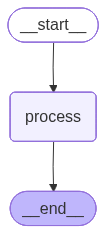

In [11]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

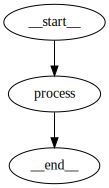

In [12]:
visualize_graph_inline(graph)

In [13]:
history = []

In [14]:
user_input ="Hello, how are you?"

In [15]:
history.append(HumanMessage(content=user_input))
state = {
    "messages": history
}
result = app.invoke(state)
ai_message = result['messages'][-1]
print(f"AI: {ai_message.content}")
history.append(ai_message)


AI: I am doing well, thank you for asking! How are you today?



**lets make it more fun**

In [16]:
llm = ChatOllama(
    model="qwen3:1.7b-q4_K_M",
    timeout=30,
    base_url="http://127.0.0.1:11434",
    stream=True,
)

In [17]:
def stream_process(state:AgentState) -> AgentState:
    response = ""
    print("AI: ", end="")
    for chunk in llm.stream(state['messages']):
        if chunk.content:   # ignore empty chunks
            print(f"{chunk.content}", end="", flush=True)
            response += chunk.content
    print()  # for newline after streaming is done
    state['messages'].append(AIMessage(content=response))
    return state

In [18]:
graph = StateGraph(AgentState)
graph.add_node("process", stream_process)
graph.add_edge(START , "process")
graph.add_edge("process" , END)
app = graph.compile()

In [19]:
user_inputs = [
    "Hello, how are you? my name is zkaria",
    "what is my name from the previouse message",
    "and finally what is ai and what do you think ai is cable of in 2030?"
]
history = []

In [20]:
for user_input in user_inputs:
    print(f"user ask: {user_input}\n")
    history.append(HumanMessage(content=user_input))
    state = {
        "messages": history
    }
    result = app.invoke(state)
    ai_message = result['messages'][-1]
    # print(f"AI: {ai_message.content}")
    history.append(ai_message)


user ask: Hello, how are you? my name is zkaria

AI: Hello, zkaria! 😊 How are you? I'm doing great, thanks for asking! If you have any questions or need help, just let me know—I'm here to assist you! 🌟
user ask: what is my name from the previouse message

AI: You're welcome! Your name from the previous message was **zkaria**. 😊 If you have any questions or need help, feel free to ask! 🌟
user ask: and finally what is ai and what do you think ai is cable of in 2030?

AI: You're asking about the future of AI, and here's a concise breakdown:

### **What is AI?**  
AI (Artificial Intelligence) refers to systems designed to perform tasks that typically require human intelligence, such as reasoning, problem-solving, language understanding, and decision-making. It relies on algorithms, data, and computational power to mimic human capabilities. AI can be categorized into subfields like **machine learning**, **natural language processing (NLP)**, and **computer vision**, among others.

---

### 

### Single-agent ReAct-style loop
Classic **ReAct** pattern (Reason + Act) implemented in the simplest possible way:

- LLM decides whether to call tools or give final answer
- Tools execute → results fed back to LLM
- Loop continues until no more tool calls

#### What is ReAct?

ReAct = **Reasoning + Acting**

The agent thinks step-by-step, decides if it needs external help (tools), calls them if necessary, observes the result, and repeats until it can give a final answer.

In this implementation we use:

- **State**: just a list of messages (with automatic appending via `add_messages`)
- **LLM** → bound to tools so it can output `tool_calls`
- **Two nodes**:
  - `our_agent`: calls the LLM → produces thought + possible tool calls
  - `tools`: executes any called tools → appends **ToolMessage** results
- **Conditional edge**: after agent → check if there are tool calls
  - Yes → go to `tools`
  - No → END (final answer ready)

→ Perfect first "real" agent example after the minimal chat loop
```graph
LLM → decide tool or final answer → tools → back to LLM → repeat
```

In [21]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [22]:

class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [23]:
@tool
def add(a: int, b: int) -> int:
    """This is an addition function that adds 2 numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]

In [24]:
model = ChatOpenAI(name="gpt-4o-mini", temperature=0.5, api_key=openai_api_key)
model_with_tools = model.bind_tools(tools)

In [25]:
def model_call(state: AgentState) -> dict:
    system_prompt = SystemMessage(
        content="You are a helpful math assistant. "
                "Use the provided tools when you need to calculate. "
                "Always think step-by-step before deciding to use a tool or answer."
    )
    response = model_with_tools.invoke([system_prompt] + state["messages"])    
    return {"messages": [response]}

In [26]:
def should_continue(state: AgentState) -> str:
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    return "continue"

In [36]:
graph = StateGraph(AgentState)

graph.add_node("our_agent", model_call)
graph.add_node("tools", ToolNode(tools))     

graph.add_edge(START, "our_agent")

# Conditional after agent
graph.add_conditional_edges(
    "our_agent",
    should_continue,                       
    {
        "continue": "tools",
        "end":      END,
    },
)

graph.add_edge("tools", "our_agent")         # after tools → back to thinking

app = graph.compile()

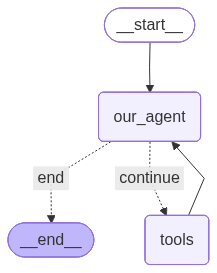

In [37]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {
    "messages": [
        (
            "user",
            "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.",
        )
    ]
}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (call_67QYOqmDxBOQ4mveb7Qxis5M)
 Call ID: call_67QYOqmDxBOQ4mveb7Qxis5M
  Args:
    a: 40
    b: 12
  multiply (call_LT4iObzKqyuXNHLmDYOqidIL)
 Call ID: call_LT4iObzKqyuXNHLmDYOqidIL
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

The sum of 40 + 12 is 52. When you multiply 52 by 6, you get 312.

Here's a joke for you:
Why was the math book sad?
Because it had too many problems.


** create agent with parallel tool messages **

In [30]:
model = ChatOpenAI(name="gpt-4o-mini", temperature=0.5, api_key=openai_api_key)
model_with_tools = model.bind_tools(tools)

In [31]:
def model_call(state: AgentState) -> dict:
    system_prompt = SystemMessage(
        content="You are a helpful math assistant. "
                "Use the provided tools when you need to calculate. "
                "Always think step-by-step before deciding to use a tool or answer."
    )
    response = model_with_tools.invoke([system_prompt] + state["messages"])    
    return {"messages": [response]}

In [32]:
def should_continue(state: AgentState) -> str:
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    return "continue"

In [38]:
from langchain_core.messages import ToolMessage

def parallel_tool_handler(state: AgentState):
    last_message = state["messages"][-1]
    tool_messages = []

    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_call_id = tool_call["id"]

        # Find correct tool
        tool = next(t for t in tools if t.name == tool_name)

        # Execute tool
        result = tool.invoke(tool_args)

        # Create proper ToolMessage
        tool_messages.append(
            ToolMessage(
                content=str(result),
                name=tool_name,
                tool_call_id=tool_call_id,
            )
        )
    print(f"Executed tools with results: {[m.content for m in tool_messages]}")
    return {"messages": tool_messages}

In [39]:
graph = StateGraph(AgentState)

graph.add_node("our_agent", model_call)
graph.add_node("tools", parallel_tool_handler)    

graph.add_edge(START, "our_agent")

# Conditional after agent
graph.add_conditional_edges(
    "our_agent",
    should_continue,                       
    {
        "continue": "tools",
        "end":      END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

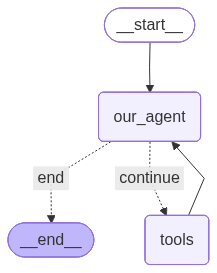

In [40]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {
    "messages": [
        (
            "user",
            "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.",
        )
    ]
}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (call_SZk0pMXwFGlpSHUHQ40LEUk8)
 Call ID: call_SZk0pMXwFGlpSHUHQ40LEUk8
  Args:
    a: 40
    b: 12
  multiply (call_1DfrssJrCVlumJNtNKYLCXHU)
 Call ID: call_1DfrssJrCVlumJNtNKYLCXHU
  Args:
    a: 52
    b: 6
Executed 2 tool calls.
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

The sum of 40 + 12 is 52. When you multiply 52 by 6, you get 312.

As for the joke: Why did the math book look sad? Because it had too many problems. 😄


## Sequential Pipeline – Fixed Linear Chain in LangGraph

Classic prompt-chaining pattern:

Node1: Summarize the input text  
Node2: Translate the summary to Arabic  
Node3: Critique / improve the translation  
→ END

→ No decisions, no branching, just step-by-step transformation
### Goal of this pattern

Many real applications are just **multi-step transformations** of text/data:

- Summarize long document  
- Translate summary  
- Make it more formal / shorter / SEO-friendly  
- Generate tweet version  
- etc.

LangGraph makes this very clean and composable — each step is a node that receives the previous output and adds/modifies the state.

In [41]:
class ChainState(TypedDict):
    text: str                   
    summary: str                 
    translation: str             
    critique: str               

In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7,
    api_key= google_api_key
)

**create the nodes**

In [45]:
def summarize_node(state: ChainState) -> ChainState:
    prompt = f"""Summarize the following text in 2-4 concise sentences:
    {state['text']}
    Summary:"""
    response = llm.invoke(prompt)
    return {"summary": response.content.strip()}

In [46]:
def translate_node(state: ChainState) -> ChainState:
    prompt = f"""Translate the following summary to formal Modern Egyption Arabic:
    {state['summary']}
    Translation:
"""
    response = llm.invoke(prompt)
    return {"translation": response.content.strip()}

In [47]:
def critique_node(state: ChainState) -> ChainState:
    prompt = f"""You are an expert editor.
    Review this Arabic translation of an English summary.
    Check for:
    - Accuracy (does it keep the original meaning?)
    - Natural flow & fluency
    - Grammar & style

    If needed, provide an improved version.
    If it's already good, just say "Translation is excellent."

    Summary (EN): {state['summary']}
    Translation (AR): {state['translation']}

    Your critique and final version:"""
    response = llm.invoke(prompt)
    return {"critique": response.content.strip()}

**build the graph**

In [48]:
graph = StateGraph(ChainState)

graph.add_node("summarize", summarize_node)
graph.add_node("translate", translate_node)
graph.add_node("critique", critique_node)

# Fixed linear path
graph.add_edge(START, "summarize")
graph.add_edge("summarize", "translate")
graph.add_edge("translate", "critique")
graph.add_edge("critique", END)

app = graph.compile()

**display the new langgraph node**

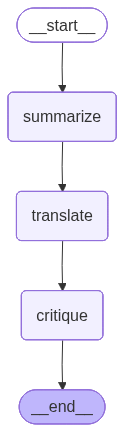

In [49]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [50]:
ex_text = """
LangGraph is a powerful framework for building agentic AI systems using a graph-based approach.
Large language models are powerful tools but can produce hallucinations.
Developers must implement guardrails and validation layers to ensure reliability.
"""

In [51]:
initial_state = {"text": ex_text}

# Stream the intermediate states (very nice for tutorials)
for step in app.stream(initial_state, stream_mode="values"):
    print("Current state:")
    for k, v in step.items():
        if v:  # skip empty fields
            print(f"  {k}:\n  {v[:120]}{'...' if len(v)>120 else ''}")
    print("-"*60)

Current state:
  text:
  
LangGraph is a powerful framework for building agentic AI systems using a graph-based approach.
Large language models a...
------------------------------------------------------------
Current state:
  text:
  
LangGraph is a powerful framework for building agentic AI systems using a graph-based approach.
Large language models a...
  summary:
  LangGraph provides a graph-based framework for building agentic AI systems. While large language models are powerful com...
------------------------------------------------------------
Current state:
  text:
  
LangGraph is a powerful framework for building agentic AI systems using a graph-based approach.
Large language models a...
  summary:
  LangGraph provides a graph-based framework for building agentic AI systems. While large language models are powerful com...
  translation:
  يوفر LangGraph إطار عمل قائم على الرسوم البيانية لبناء أنظمة ذكاء اصطناعي وكيلية. بينما تعد نماذج اللغة الكبيرة مكونات ق...
----------------

## Router / Conditional Branching in LangGraph

Pattern: **Classify → Route → Specialist**

- One entry node classifies the query (e.g. math / general / search / joke)
- **Conditional edges** dispatch to different nodes based on classification
- Each specialist handles its domain → final response

→ No loops here — fixed decisions, but dynamic path
### Why this pattern?

Many real assistants need to **understand intent first**, then delegate:

- Math questions → calculator agent
- General chat → friendly LLM
- Search needed → retrieval / web agent
- Jokes → fun mode

LangGraph makes this elegant with `add_conditional_edges` + a routing function.

### State Design

We'll use a simple state with:
- `messages`: conversation history (for context)
- `category`: classification result (added by router)

In [60]:
class RouterState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    category: str

In [53]:
llm = ChatOllama(
    model="qwen3:1.7b-q4_K_M",
    timeout=30,
    base_url="http://127.0.0.1:11434",
    stream=True,
)

In [54]:
from langchain_core.prompts import ChatPromptTemplate
router_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a smart router.
Classify the user query into exactly one category:
- "math": if it involves numbers, calculations, equations
- "joke": if they ask for a joke or humor
- "general": everything else (chat, questions, opinions...)

Respond with ONLY the category name, nothing else."""),
    ("human", "{query}")
])

In [55]:
router_chain = router_prompt | llm

**classify query**

In [57]:
def classify_query(state: RouterState) -> RouterState:
    # Use the last user message as query
    query = state["messages"][-1].content
    category = router_chain.invoke({"query": query}).content.strip().lower()
    
    # Fallback if LLM hallucinates
    if category not in ["math", "joke", "general"]:
        category = "general"
    
    return {"category": category}

**graph nodes**

In [64]:
def math_node(state: RouterState) -> RouterState:
    # Simple placeholder — in real app use tool calling here
    response = llm.invoke([
        ("system", "You are a precise math assistant."),
        *state["messages"]
    ])
    return {"messages": [response]}

def joke_node(state: RouterState) -> RouterState:
    response = llm.invoke([
        ("system", "You are a funny comedian. Tell short, clever jokes."),
        *state["messages"]
    ])
    return {"messages": [response]}

def general_node(state: RouterState) -> RouterState:
    response = llm.invoke([
        ("system", "You are a helpful, friendly assistant."),
        *state["messages"]
    ])
    return {"messages": [response]}

In [65]:
from typing import Literal
def route_query(state: RouterState) -> Literal["math", "joke", "general"]:
    return state["category"]

In [66]:
graph = StateGraph(RouterState)

graph.add_node("classify", classify_query)
graph.add_node("math", math_node)
graph.add_node("joke", joke_node)
graph.add_node("general", general_node)

# Entry point → always classify first
graph.add_edge(START, "classify")

# Conditional routing based on category
graph.add_conditional_edges(
    "classify",
    route_query,
    {
        "math": "math",
        "joke": "joke",
        "general": "general",
    }
)

# All specialists go to END
graph.add_edge("math", END)
graph.add_edge("joke", END)
graph.add_edge("general", END)

app = graph.compile()

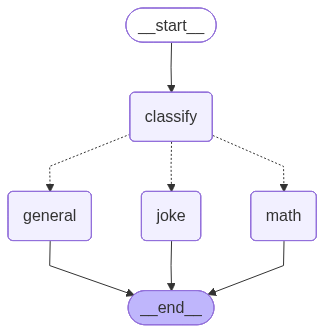

In [67]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [68]:
## print the final response with category
def print_final(state):
    last_msg = state["messages"][-1]
    print(f"\nCategory: {state.get('category', 'unknown')}")
    last_msg.pretty_print()

In [69]:
result = app.invoke({"messages": [("human", "What is 17 × 42?")]})
print_final(result)


Category: math
================================== Ai Message ==================================

The product of 17 and 42 can be calculated using the distributive property:

$$
17 \times 42 = 17 \times (40 + 2) = (17 \times 40) + (17 \times 2)
$$

Breaking it down:
- $17 \times 40 = 680$
- $17 \times 2 = 34$

Adding the results:
$$
680 + 34 = 714
$$

**Final Answer:**  
$$
\boxed{714}
$$


In [70]:
result = app.invoke({"messages": [("human", "Tell me a programming joke!")]})
print_final(result)


Category: joke
================================== Ai Message ==================================

Why did the programmer start a cat business?  
Because they wanted to make a *loop*! 🐱💻  

Or, if you prefer:  
Why did the programmer always get lost in the woods?  
Because they didn't know the *loop*! 🌳💻


In [71]:
result = app.invoke({"messages": [("human", "What's the weather like in Cairo today?")]})
print_final(result)


Category: general
================================== Ai Message ==================================

As of my last update, the weather in Cairo, Egypt, is currently **32°C** with **high humidity** and **partly cloudy** skies. The temperature is quite hot, so staying hydrated and wearing light clothing is recommended. Keep in mind that weather can change rapidly, so check a reliable weather service for the most up-to-date information. 🌤️


## Multi-Agent Collaboration / Network Pattern in LangGraph

**Peer-to-peer collaboration** style:

- Multiple specialized agents share the **same message history** (scratchpad)
- Each agent can read everything previous agents wrote → decide to contribute or hand off
- No single "boss" — agents decide when to stop via a shared condition
- Agents pass control by appending messages → loop until final answer

→ Great for open-ended tasks where agents "bounce ideas" (research, brainstorming, writing)
### What is this pattern?

In the **network / collaboration** style:

- All agents see the full conversation history (`messages`)
- Each agent has its own **system prompt** (personality/role/toolset)
- They take turns: one thinks → appends message → next decides if it can help or pass
- A **shared termination condition** (e.g. "FINAL ANSWER" keyword or no tool calls + specific phrase)
- Often uses **one router** or **simple cycling** to select next speaker

This mimics a team chat where everyone sees the thread and jumps in when relevant.

Official LangGraph example: [Multi-agent collaboration](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/)

In [85]:
class CollaborationState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [86]:
llm = ChatOpenAI(name="gpt-4o-mini", temperature=0.5, api_key=openai_api_key)

**create web search tool**

In [87]:
from langchain_core.tools import tool
import ddgs
@tool
def duckduckgo_search(query: str, max_results: int = 5) -> str:
    """Search the web using DuckDuckGo"""
    try:
        results = []
        with ddgs.DDGS() as search:
            for r in search.text(query, max_results=max_results):
                results.append(
                    f"{r['title']}\n{r['body']}\nURL: {r['href']}"
                )

        return "\n\n".join(results)
    except Exception as e:
        return f"Error searching the web: {e}"

In [88]:
tools = [duckduckgo_search]
tool_node = ToolNode(tools)

In [89]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
def create_agent(name: str, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt + "\n\nYou are part of a team. Read the full conversation and contribute if you can help. "
                  "If the task is complete, end your message with: FINAL ANSWER: [your final output]"),
        MessagesPlaceholder(variable_name="messages"),
    ])
    return prompt | llm.bind_tools(tools if "Researcher" in name else [])  # only researcher has tools

In [90]:
researcher = create_agent(
    "Researcher",
    "You are a thorough researcher. Gather facts, search when needed, provide accurate info."
)

writer = create_agent(
    "Writer",
    "You are a clear writer. Synthesize information from the team into coherent, well-structured text."
)

critic = create_agent(
    "Critic",
    "You are a critical reviewer. Check accuracy, clarity, completeness. Suggest improvements or approve."
)

**agent node**

In [91]:
def researcher_node(state: CollaborationState):
    response = researcher.invoke({"messages": state["messages"]})
    return {"messages": [response]}

def writer_node(state: CollaborationState):
    response = writer.invoke({"messages": state["messages"]})
    return {"messages": [response]}

def critic_node(state: CollaborationState):
    response = critic.invoke({"messages": state["messages"]})
    return {"messages": [response]}

**Implement router**

In [92]:
agent_order = ["researcher", "writer", "critic"]
def next_agent(state: CollaborationState) -> str:
    last_msg = state["messages"][-1]
    if "FINAL ANSWER:" in last_msg.content:
        return END
    last_agent = None
    for m in reversed(state["messages"]):
        if hasattr(m, "name") and m.name in agent_order:
            last_agent = m.name
            break
    
    if last_agent is None:
        return "researcher"  # start with researcher
    
    idx = (agent_order.index(last_agent) + 1) % len(agent_order)
    return agent_order[idx]

**Build agent graph**

In [93]:
graph = StateGraph(CollaborationState)

graph.add_node("researcher", researcher_node)
graph.add_node("writer", writer_node)
graph.add_node("critic", critic_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "researcher")  # start with researcher

graph.add_conditional_edges(
    "researcher",
    lambda s: "tools" if s["messages"][-1].tool_calls else next_agent(s),
    {"tools": "tools", END: END, "researcher": "researcher", "writer": "writer", "critic": "critic"}
)

graph.add_conditional_edges(
    "writer",
    next_agent,
    {END: END, "researcher": "researcher", "writer": "writer", "critic": "critic"}
)

graph.add_conditional_edges(
    "critic",
    next_agent,
    {END: END, "researcher": "researcher", "writer": "writer", "critic": "critic"}
)

graph.add_edge("tools", "researcher") 

app = graph.compile()

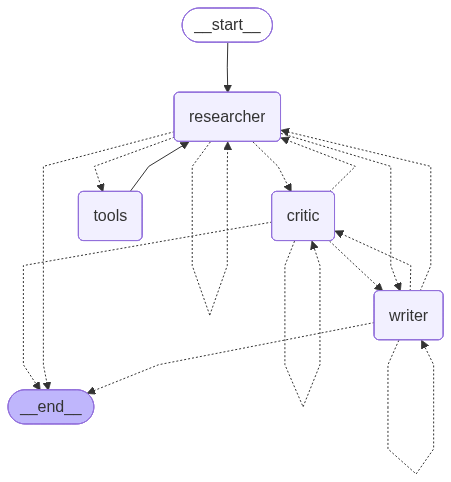

In [94]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [95]:
initial_input = {
    "messages": [("human", "Write a short report about the latest AI Agent news from the past week and what ai will be canle to do in 2030.")]
}

for chunk in app.stream(initial_input, stream_mode="values"):
    last_msg = chunk["messages"][-1]
    print(f"\n{last_msg.type.upper()} ({getattr(last_msg, 'name', 'unknown')}):")
    print(last_msg.content[:300] + "..." if len(last_msg.content) > 300 else last_msg.content)
    print("-" * 60)


HUMAN (None):
Write a short report about the latest AI Agent news from the past week and what ai will be canle to do in 2030.
------------------------------------------------------------

AI (None):

------------------------------------------------------------

TOOL (duckduckgo_search):
AI News | Latest News | Insights Powering AI -Driven Business Growth
AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterprise AI , and emerging tech worldwide. AI Business Strategy, Featured News , Service Industry AI , World of Work. AI use surges ...
------------------------------------------------------------

AI (None):
Here are some of the latest AI Agent news from the past week:

1. **AI News**: Provides updates on artificial intelligence, machine learning, deep learning, enterprise AI, and emerging tech worldwide. AI use has surged at Travelers as call center roles reduce. [Link to article](https://www.artificia...
------------------------------

In [96]:
print("\nFinal report generated by the team:")
final_msg = chunk["messages"][-1]
print(final_msg.content)


Final report generated by the team:
FINAL ANSWER: Here are some of the latest AI Agent news from the past week:

1. **AI News**: Provides updates on artificial intelligence, machine learning, deep learning, enterprise AI, and emerging tech worldwide. AI use has surged at Travelers as call center roles reduce. [Link to article](https://www.artificialintelligence-news.com/)

2. **OpenAI Introduces ChatGPT Agent**: Pro, Plus, and Team users can now activate ChatGPT’s new agentic capabilities directly through the tools dropdown from the composer by selecting ‘agent mode’ at any point in any conversation. [Link to article](https://openai.com/index/introducing-chatgpt-agent/)

3. **Botpress**: A platform to build powerful AI agents with an intuitive building experience powered by the latest LLMs. Get started for free. [Link to platform](https://botpress.com/)

4. **Moltbook Study**: AI agents have their own social network called Moltbook, designed solely for AI systems and currently hosting

## Reflection / Critique / Self-Refine Loop in LangGraph

**Self-improvement pattern** (also called Reflexion, Self-Refine, Critic + Revise):

- Generator → produces initial output
- Critic / Reflector → evaluates quality, finds flaws, gives feedback
- Generator revises → using previous output + critique
- Repeat until good enough (or max iterations)

→ Very powerful for improving quality in writing, code, planning, reasoning

In [149]:
class RefineState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    draft: str                
    critique: str             
    iteration: int
    max_iterations: int

In [ ]:
llm = ChatOpenAI(name="gpt-4o-mini", temperature=0.5, api_key=openai_api_key)

**generator node**

In [169]:
generator_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert writer. Improve the draft based on the critique (if any)."),
    ("human", """Task: {task}
Current draft: {draft}
Critique / feedback: {critique}

Generate an improved version.""")
])

In [170]:
generator_chain = generator_prompt | llm.with_config({"max_output_tokens": 800})  

In [171]:
def generate_node(state: RefineState):
    task = state["messages"][0].content
    draft = state.get("draft", "")
    critique = state.get("critique", "No critique yet — generate initial version.")
    
    response_msg = generator_chain.invoke({
        "task": task,
        "draft": draft,
        "critique": critique
    })
    print(f"content from generator: {response_msg}...")

    # Handle both single AIMessage and list[AIMessage]
    if isinstance(response_msg, list):
        response_msg = response_msg[0] if response_msg else AIMessage(content="")
    
    content = response_msg.content or ""
    
    return {
        "draft": content.strip(),
        "messages": [response_msg],           # keep original message object
        "iteration": state["iteration"] + 1
    }

**critic node**

In [172]:
critic_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a strict, expert critic.
Evaluate the draft for:
- Completeness & accuracy
- Clarity & structure
- Style & conciseness
- Any logical gaps or errors

Give specific, actionable feedback.
If the draft is already excellent, say exactly: "APPROVED"."""),
    ("human", "Draft to critique:\n{draft}")
])

In [173]:
critic_chain = critic_prompt | llm

def critique_node(state: RefineState):
    response = critic_chain.invoke({"draft": state["draft"]})
    
    if isinstance(response, list):
        content = response[0].content if response else ""
    else:
        content = response.content
    
    return {
        "critique": content.strip(),
        "messages": [AIMessage(content=content)]
    }

**Router**

In [174]:
def should_continue(state: RefineState) -> Literal["generate", "__end__"]:
    if state["iteration"] >= state["max_iterations"]:
        return END
    
    last_critique = state["critique"].lower()
    if "approved" in last_critique or "excellent" in last_critique:
        return END
    
    return "generate"

**build graph**

In [175]:
graph = StateGraph(RefineState)

graph.add_node("generate", generate_node)
graph.add_node("critique", critique_node)

graph.add_edge(START, "generate")
graph.add_edge("generate", "critique")
graph.add_conditional_edges("critique", should_continue, {"generate": "generate", END: END})

app = graph.compile()

**draw the graph**

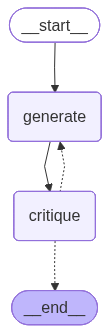

In [176]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [177]:
task = "Write a concise 3-sentence summary of why Cairo is a great city to not live in."

initial_state = {
    "messages": [("human", task)],
    "draft": "",
    "critique": "",
    "iteration": 0,
    "max_iterations": 4
}

for chunk in app.stream(initial_state, stream_mode="values"):
    print(f"\nIteration {chunk['iteration']}:")
    if "draft" in chunk and chunk["draft"]:
        print(f"Iteration {chunk['iteration']}:")
        print("Draft:", chunk["draft"][:200] + "...")
        print("Critique:", chunk.get("critique", "—")[:200] + "...")
        print("-" * 70)


Iteration 0:
content from generator: content="Cairo's congested streets, high levels of pollution, and overcrowded living conditions make it a challenging city to live in. The lack of adequate infrastructure, including unreliable public transportation and limited access to clean water, further detracts from the quality of life in Cairo. Additionally, the city's political instability and security concerns add to the reasons why it may not be an ideal place to live." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 65, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DCkhkXjTuetDO8Qg5bYa7QAFVowWy', 'service_tier': 'default', 'finish_reason': '

## Human-in-the-Loop in LangGraph

**Interrupt & wait for human input** pattern:

- Graph runs normally until a specific node or condition
- Pauses execution → returns current state
- Waits for human edit/approval/input
- Resumes with updated state

→ Essential for safety, quality control, debugging in production agents

**you can see the code at [zkzkAgent Human in loop agent with tools](https://github.com/zkzkGamal/zkzkAgent/blob/main/core/agent.py)**